# Module 5 Lesson 3 Practice Assessment

This lesson covered the import data concepts in deep learning models and the corresponding programming APIs in MXNet Gluon that we use when training these models. In particular, you learned how to define gluon `Datasets`, how to transform and preprocess those datasets with `vision.transforms` and how to feed the datasets into neural networks during training with gluon `DataLoaders`. This practice assessment will allow you to become familiar with these tools in preparation for building your first end to end deep learning training system in the next lesson.

In [1]:
from mxnet import gluon
from matplotlib import pyplot

import os
from pathlib import Path

In [2]:
M5_DATA = Path(os.getenv('DATA_DIR', '../../data'), 'module_5')
M5_IMAGES = Path(M5_DATA, 'images')
M5_MODELS = Path(M5_DATA, 'models')

---
## Question 1

First, let's get a particular dataset for this exercise. We will be using the CIFAR10 dataset which is built-in in MXNet in the `gluon.data.vision.datasets` library.

In the following cell you will complete the function definition so that it returns the CIFAR10 dataset from MXNet. The function should return both the training and the validation dataset. To make things more exciting, the function should examine both the training and validation dataset and return the index that corresponds to the first occurrence of each class in CIFAR10. 

For example, the first class (label) in the CIFAR10 training dataset is `6`, this corresponds to index `0` in the training dataset. For the remaining classes in the dataset, find the index in the training dataset where that class first occurs. Repeat the same process for the validation dataset. To summarize, the `get_cifar_10_dataset` function below should return 4 values. The CIFAR10 training dataset, the indices of the training dataset that correspond to the first occurrence of each class, The CIFAR10 validation dataset and the indices of the validation dataset that correspond to the first occurrence of each class.

<font color='red'>**CAUTION!**</font>: Although the notebook interface has internet connectivity, the **autograders are not permitted to access the internet**. We have already downloaded the correct models and data for you to use so you don't need access to the internet. Set the `root` parameter to `M5_IMAGES` when using a preset dataset. Usually, in the real world, you have internet access, so setting the `root` parameter isn't required (and it's set to `~/.mxnet` by default).

In [9]:
def get_cifar10_dataset():
    """
    Should create the cifar 10 network and identify the dataset index of the first time each new class appears
    
    :return: tuple of training and validation dataset as well as label indices
    :rtype: (gluon.data.Dataset, dict[int:int], gluon.data.Dataset, dict[int:int])
    """
    train_data = None
    val_data = None
    train_indices = {}
    val_indicies = {}
    
    # Use `root=M5_IMAGES` for your dataset
    # YOUR CODE HERE
    import numpy as np
    
    train_data = gluon.data.vision.datasets.CIFAR10(train = True,root = M5_IMAGES)
    #Train
    train_labels = [i[1] for i in train_data]
    unique_labels = list(set(train_labels))
    for item in unique_labels:
        train_indices[item] = np.argwhere(np.array(train_labels)==item)[0][0]
        
    #Validation
    val_data = gluon.data.vision.datasets.CIFAR10(train = False,root = M5_IMAGES)
    val_labels = [i[1] for i in val_data]
    unique_val_labels = list(set(val_labels))
    for item in unique_val_labels:
        val_indicies[item] = np.argwhere(np.array(val_labels)==item)[0][0]
    
    return train_data, train_indices, val_data, val_indicies

In [10]:
_, _, v, i = get_cifar10_dataset()

assert isinstance(v, gluon.data.vision.datasets.CIFAR10)
for k in range(10):
    assert v[i[k]][1] == k

Now we can visualize what classes are present in the CIFAR10 dataset. If your implementation for `get_cifar_10` dataset is correct, the code cell below should plot two rows of images. Take a look at the first row, do you recognize some of the classes there? Compare images from the same class labels in the first row to the second row. Do the validation images look like they belong to the same class?

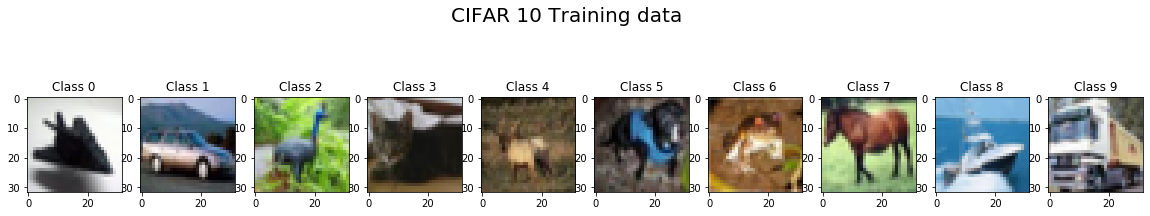

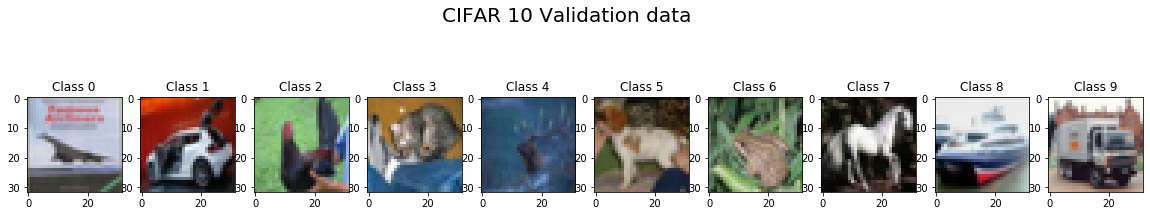

In [11]:
def plot_cifar10_classes(train_data, train_indices, val_data, val_indices):
    def plot_class_images(data, indices, title):
        fig, axes = pyplot.subplots(1,10, figsize=(20, 4))
        fig.suptitle(title, fontsize=20)
        for ax, idx in zip(axes, indices):
            ax.imshow(data[indices[idx]][0].asnumpy())
            ax.set_title('Class {}'.format(idx))
    plot_class_images(train_data, train_indices, 'CIFAR 10 Training data')
    plot_class_images(val_data, val_indices, 'CIFAR 10 Validation data')
        
plot_cifar10_classes(*get_cifar10_dataset())

## Question 2

Now let's define some transformations on our training dataset. In the section below you will write code for two functions - one for the training transformation and one for the validation transformation.

For the training transformation, the transform function should perform the following transforms:

* `RandomFlipLeftRight`
* `RandomCrop` to size 16 x 16

For the validation transformation, the transform function should perform only this the following transform:

* `CenterCrop` to size 16 x 16

This is representative of transformations that might be used when training deep models. The random flips and random crops provide data augmentation that can help our final trained model generalize better. However in order to evaluate the performance of the trained model in a repeatable fashion, we do not apply random transforms on the validation data.

Implement both functions below and execute the cell before moving on.

In [12]:
from mxnet.gluon.data.vision import transforms

def transform_cifar10_dataset_train():
    """
    Should create a transformation that performs both random horizontal flip and random crop
    
    :return: A gluon transform object
    :rtype: gluon.Block
    """
    
    # YOUR CODE HERE
    return transforms.Compose([transforms.RandomFlipLeftRight(),
                              transforms.RandomResizedCrop(size=(16,16))])

def transform_cifar10_dataset_val():
    """
    Should create a transformation that performs center cropping
    
    :return: A gluon transform object
    :rtype: gluon.Block
    """
    
    # YOUR CODE HERE
    return transforms.CenterCrop(size=(16, 16))

In [13]:
assert isinstance(transform_cifar10_dataset_train(), transforms.Compose)
assert isinstance(transform_cifar10_dataset_val(), transforms.CenterCrop)

assert isinstance(transform_cifar10_dataset_train()[0], transforms.RandomFlipLeftRight)
assert isinstance(transform_cifar10_dataset_train()[1], transforms.RandomResizedCrop)

Again we can visualize the results of both our training and validation transformation functions. If you correctly implemented the two functions above, then you the cell below should produces two rows just as in Question 1.

However, now the images should be a bit more pixelated due to the cropping. Can you still recognize the objects in the images. Can you identify which images have been flipped and which haven't? It might help to compare to the previous visualizations.

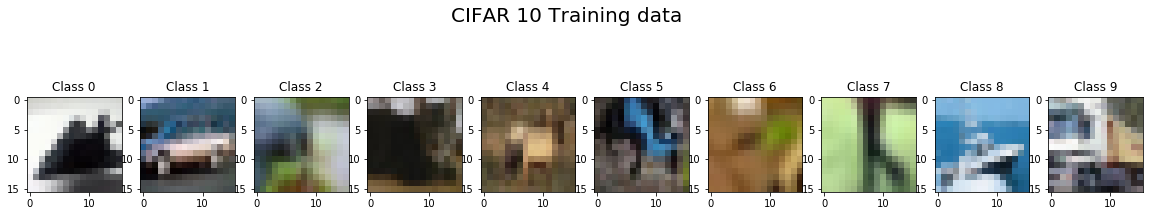

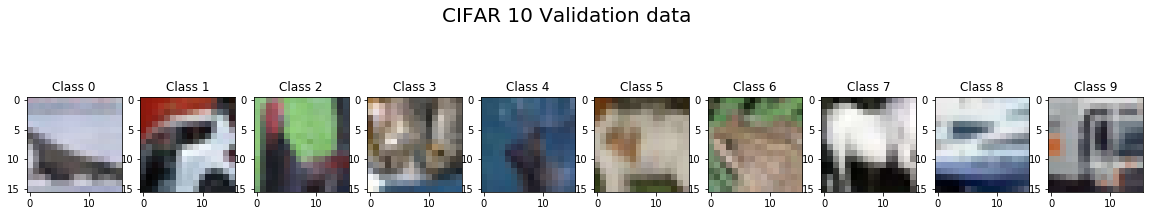

In [14]:
def plot_transformed_cifar_10_classes(train_data, train_indices, val_data, val_indices, train_transform, val_transform):
    train_data = train_data.transform_first(train_transform)
    val_data = val_data.transform_first(val_transform)
    plot_cifar10_classes(train_data, train_indices, val_data, val_indices)
    
plot_transformed_cifar_10_classes(*get_cifar10_dataset(), transform_cifar10_dataset_train(), transform_cifar10_dataset_val())

---
## Question 3

Finally, you will implement a function that takes in a dataset, a transform function and `batch_size` and returns a `gluon.data.DataLoader`. Similar to Question 2, you will implement two versions of this function - one to generate the training dataloader and the other to generate the test dataloader. Make sure that training dataloader shuffles the training dataset but the validation dataset should not shuffle the validation dataset. Once you have completed the function implementations move on to the next cell to visualize how the dataloader would function during model training.

In [15]:
def get_train_dataloader(train_dataset, train_transform, batch_size):
    """
    Should create a dataloader for training
    
    :param train_dataset: the dataset
    :type train_dataset: gluon.data.Dataset
    
    :param train_transform: the transform function
    :type train_transform: gluon.Block
    
    :param batch_size: batch size
    :type batch_size: int
    
    :return: A gluon dataloader
    :rtype: gluon.data.DataLoader
    """
    
    # YOUR CODE HERE
    train_dataset = train_dataset.transform_first(train_transform)
    return gluon.data.DataLoader(train_dataset,batch_size=batch_size)
    
def get_val_dataloader(val_dataset, val_transform, batch_size):
    """
    Should create a dataloader for validation
    
    :param val_dataset: the dataset
    :type val_dataset: gluon.data.Dataset
    
    :param val_transform: the transform function
    :type val_transform: gluon.Block
    
    :param batch_size: batch size
    :type batch_size: int
    
    :return: A gluon dataloader
    :rtype: gluon.data.DataLoader
    """
    
    # YOUR CODE HERE
    val_dataset = val_dataset.transform_first(val_transform)
    return gluon.data.DataLoader(val_dataset,batch_size=batch_size)

In [16]:
batch_size = 128
train_set, _, val_set, _ = get_cifar10_dataset()
train_dataloader = get_train_dataloader(train_set, transform_cifar10_dataset_train(), batch_size)
val_dataloader = get_val_dataloader(val_set, transform_cifar10_dataset_val(), batch_size)

assert isinstance(train_dataloader, gluon.data.DataLoader)
assert isinstance(val_dataloader, gluon.data.DataLoader)

d, l = next(iter(train_dataloader))
assert d.shape == (128, 16, 16, 3) # check Channel First and Batch Size
assert l.shape == (128,)

Now we will bring everything together into one final visualization. Instead of plotting only a single representative for CIFAR10 class, now we'll display every single image in the dataset using the dataloader. If your implementation of the two functions above is correct, the cell below should display first the entire training dataset batch by batch and then the validation set batch by batch. If you look closely, you will see that some images in each mini-batch of training data have the transformations we defined earlier apply to them.

**Note:** The next cell could take a long time to finish execution. Feel free to stop the cell execution whenever you feel like.

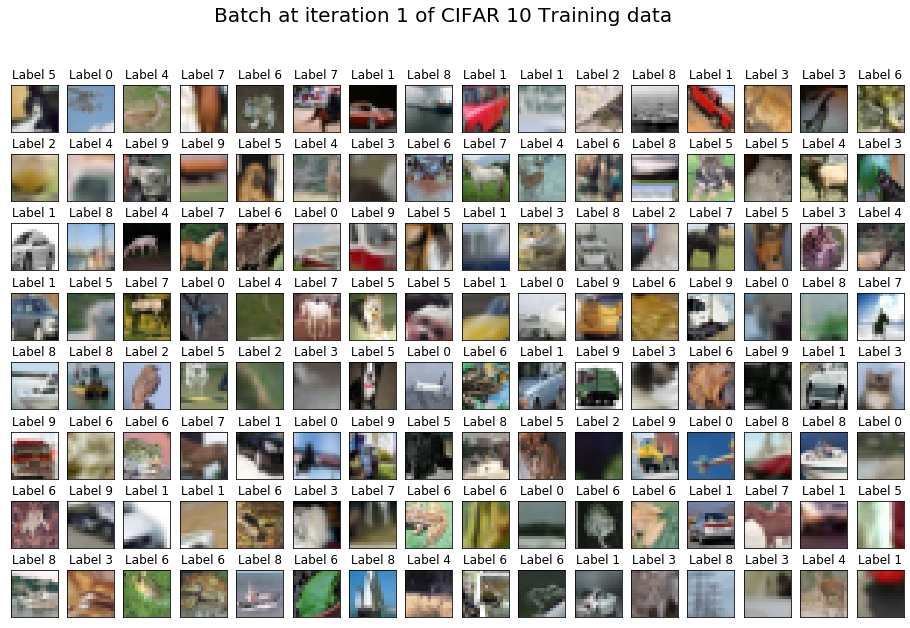

KeyboardInterrupt: 

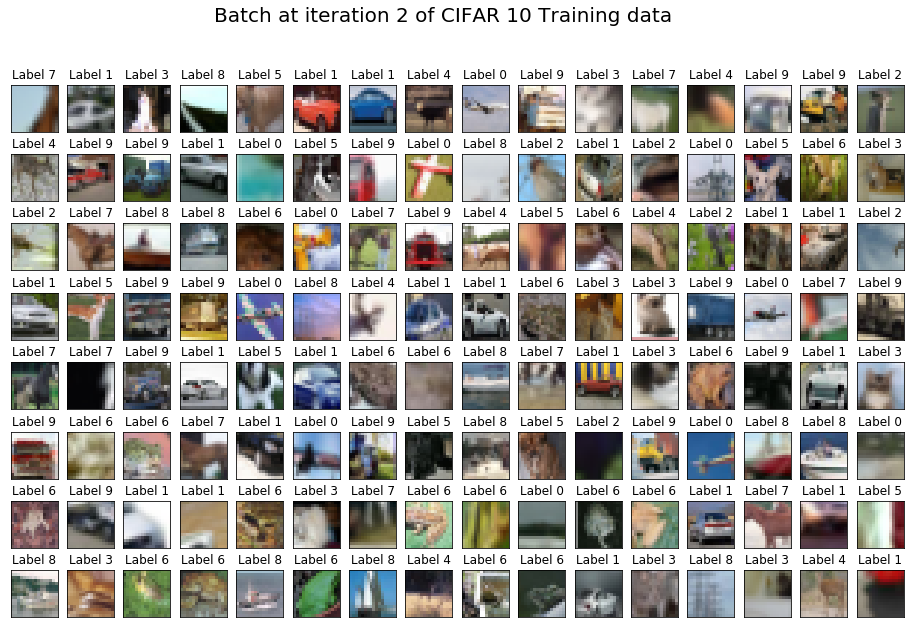

In [17]:
import time
from IPython import display

def plot_cifar10_dataloading(train_dataloader, val_dataloader, batch_size, end=3):
    def plot_batch_images(dataloader, title):
        def plot_single_batch(data, label):
            for j in range(batch_size):
                row, col = j//16, j%16
                axis = axes[row][col]
                axis.imshow(data[j, :,:,:].asnumpy())
                axis.set_title('Label {}'.format(label[j].asscalar()))
                axis.get_xaxis().set_visible(False)
                axis.get_yaxis().set_visible(False)
                
        
        fig, axes = pyplot.subplots(8,batch_size//8, figsize=(batch_size//8, 10))
        for i, (data, label) in enumerate(dataloader):
            if (i == end):
                return
            fig.suptitle(title.format(i), fontsize=20)
            plot_single_batch(data, label)
            display.clear_output(wait=True)
            display.display(pyplot.gcf())
            time.sleep(0.1)
            
    plot_batch_images(train_dataloader, 'Batch at iteration {} of CIFAR 10 Training data')
    plot_batch_images(val_dataloader, 'Batch at iteration {} of CIFAR 10 Validation data')
    

batch_size = 128
train_set, _, val_set, _ = get_cifar10_dataset()
train_dataloader = get_train_dataloader(train_set, transform_cifar10_dataset_train(), batch_size)
val_dataloader = get_val_dataloader(val_set, transform_cifar10_dataset_val(), batch_size)
plot_cifar10_dataloading(train_dataloader, val_dataloader, batch_size)